In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
pd.set_option('mode.chained_assignment', None)
pd.set_option("display.max_columns", 100)

In [2]:
os.listdir()

['.DS_Store',
 '“Bitcoin Price and its Movement Direction Prediction.ipynb',
 '未命名.ipynb',
 'bitcoin_prediction.ipynb',
 '.ipynb_checkpoints',
 'bitcoin.csv']

这里说明下，要把这个ipynb和bitcoin.csv放在一个目录下

## 读取数据 

In [3]:
df=pd.read_csv('bitcoin.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'],unit='s')
df = df.set_index('Timestamp')
df.columns = ["Open", "High", "Low","Close", "Volume_BTC", "Volume_Currency", "Weighted_Price"]

## Missing data处理 

In [4]:
is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]
is_NaN.index = is_NaN.index.year

In [5]:
missing_by_yr = is_NaN.groupby(is_NaN.index).Open.agg('sum').to_frame().join(is_NaN.index.value_counts().to_frame())
missing_by_yr.columns=["Missing_counts", "Total_counts"]
missing_by_yr["Missing rate"] = missing_by_yr.Missing_counts/missing_by_yr.Total_counts
missing_by_yr

,Missing_counts,Total_counts,Missing rate
Timestamp,,,
2011,964,968,0.995868
2012,500411,527040,0.949474
2013,205839,525600,0.391627
2014,127424,525600,0.242435
2015,146393,519128,0.281998
2016,174941,527040,0.331931
2017,42268,525600,0.080419
2018,19827,525600,0.037723
2019,17260,525600,0.032839


### Missing data主要集中在2017年前，大概半个月15天左右的分桶

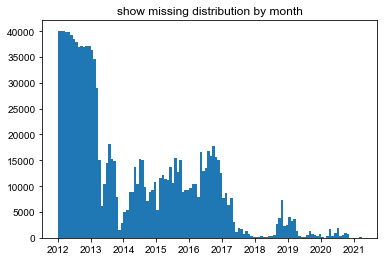

In [6]:
plt.hist(rows_with_NaN.index,bins=120)
plt.title("show missing distribution by month")
plt.show()

### Missing rate 确认
* missing的话是一行全部missing
* 整体missing rate为25.6%
* 2017年missing rate大概在50%

In [7]:
missed = pd.DataFrame()
missed['column'] = df.columns

missed['percent'] = [round(100* df[col].isnull().sum() / len(df), 2) for col in df.columns]
missed = missed.sort_values('percent',ascending=False)
missed = missed[missed['percent']>0]
missed

,column,percent
0,Open,25.6
1,High,25.6
2,Low,25.6
3,Close,25.6
4,Volume_BTC,25.6
5,Volume_Currency,25.6
6,Weighted_Price,25.6


## Interpolation
* 结论：
> * 画图出来看基本都完全重合了，尤其是2017年之后波动剧烈的时候
> * 2012年平滑的时候missing波动也不是很剧烈


In [8]:
def fill_missing(df):
    frame = df.copy(deep=True)
    ### function to impute missing values using interpolation ###
    frame['Open'] = frame['Open'].interpolate()
    frame['Close'] = frame['Close'].interpolate()
    frame['Weighted_Price'] = frame['Weighted_Price'].interpolate()
    frame['Volume_BTC'] = frame['Volume_BTC'].interpolate()
    frame['Volume_Currency'] = frame['Volume_Currency'].interpolate()
    frame['High'] = frame['High'].interpolate()
    frame['Low'] = frame['Low'].interpolate()
    return frame


df_inter = fill_missing(df)
df_inter.dropna(inplace=True)
df.dropna(inplace=True)

In [9]:
print('Orignal dataframe shape is: ' + str(df.shape))
print('Interpolated dataframe shape is: '+ str(df_inter.shape))

Orignal dataframe shape is: (3613769, 7)
Interpolated dataframe shape is: (4857377, 7)


这里是确认一下original dataframe没有被interpolated，之前pass一个copy进function发现原df被改了，纯属coding的问题，做一个确认，到时候可以删了。

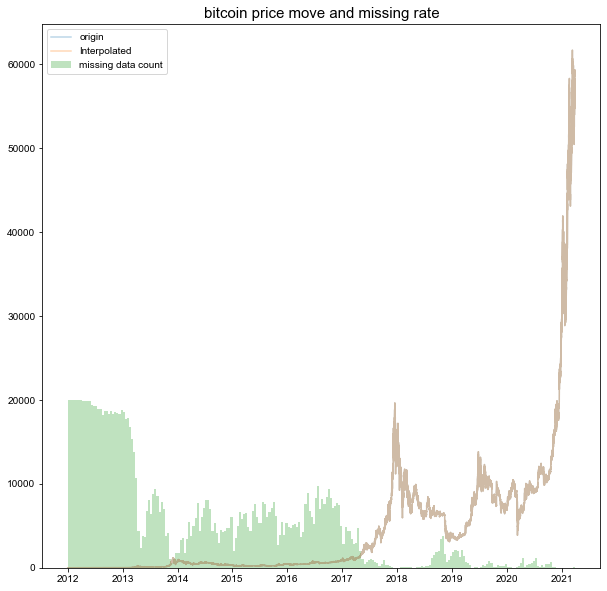

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(df.index, df.Weighted_Price, alpha= 0.3, label='origin')
ax.plot(df_inter.index, df_inter.Weighted_Price, alpha= 0.3, label='Interpolated')
ax.hist(rows_with_NaN.index,bins=240, alpha=0.3, label='missing data count')
ax.legend()
ax.set_title('bitcoin price move and missing rate', fontsize=15)
plt.show()

## Percentage return

### return直接画图

In [11]:
df["Price"] = df[["Open","High","Low","Close"]].mean(axis=1)
df["Return"] = df["Price"].diff()
df["Percentage_Return"] = ((df["Return"].shift(periods=-1))/ (df["Price"])).shift(periods=1)
df["Volume_diff"] = df["Volume_Currency"].diff()
df["Percentage_Volume"] = ((df["Volume_diff"].shift(periods=-1))/ (df["Price"])).shift(periods=1)


df["Vol_MA60"] = df.Volume_Currency.rolling(window=60).sum()
df["Vol_MA120"] = df.Volume_Currency.rolling(window=120).sum()

In [12]:
df.head()

,Open,High,Low,Close,Volume_BTC,Volume_Currency,Weighted_Price,Price,Return,Percentage_Return,Volume_diff,Percentage_Volume,Vol_MA60,Vol_MA120
Timestamp,,,,,,,,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,4.390,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 15:50:00,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,4.390,0.000,0.000000,208.720000,47.544419,NaN,NaN
2011-12-31 16:59:00,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411,4.535,0.145,0.033030,-39.339662,-8.961199,NaN,NaN
2011-12-31 17:00:00,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,4.580,0.045,0.009923,-130.160338,-28.701287,NaN,NaN
2012-01-01 04:16:00,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,4.580,0.000,0.000000,-34.340840,-7.498000,NaN,NaN


Text(0.5, 1.0, 'Percentage Volume')

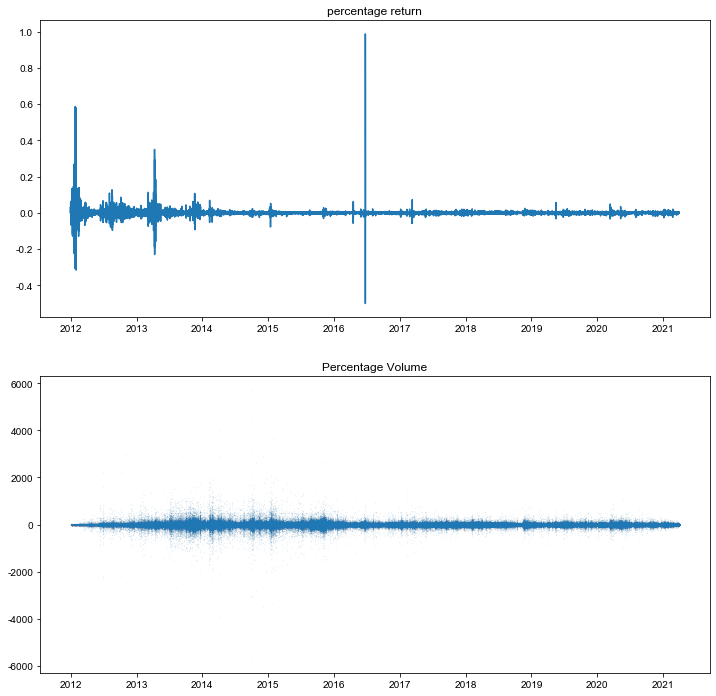

In [13]:
fig, ax = plt.subplots(2,1,figsize=(12,12))
ax[0].plot(df.index, df["Percentage_Return"])
ax[0].set_title("percentage return")

ax[1].scatter(df.index, df.Percentage_Volume, s=0.001)
ax[1].set_title("Percentage Volume")

### return删掉 1 和 99 分位的异常值
* Note: 这里我试了删掉5和95分位的异常值，发现画出来的东西就是一张蓝图，感觉不是很有意义？\
    还是想取的宽一点看看吧

In [14]:
low, high = 0.01, 0.99
selected_columns = ["Percentage_Return", "Percentage_Volume"]

quant_df = df[selected_columns].quantile([low, high])
quant_df

,Percentage_Return,Percentage_Volume
0.01,-0.004313,-83.656998
0.99,0.004219,85.030174


In [15]:
for col in selected_columns:
    df.drop(df[df[col] <= quant_df.loc[low, col]].index, axis=0, inplace=True)
    df.drop(df[df[col] >= quant_df.loc[high, col]].index, axis=0, inplace=True)

#### 过滤了异常值之后看一下一个时间段的return percentage分布 

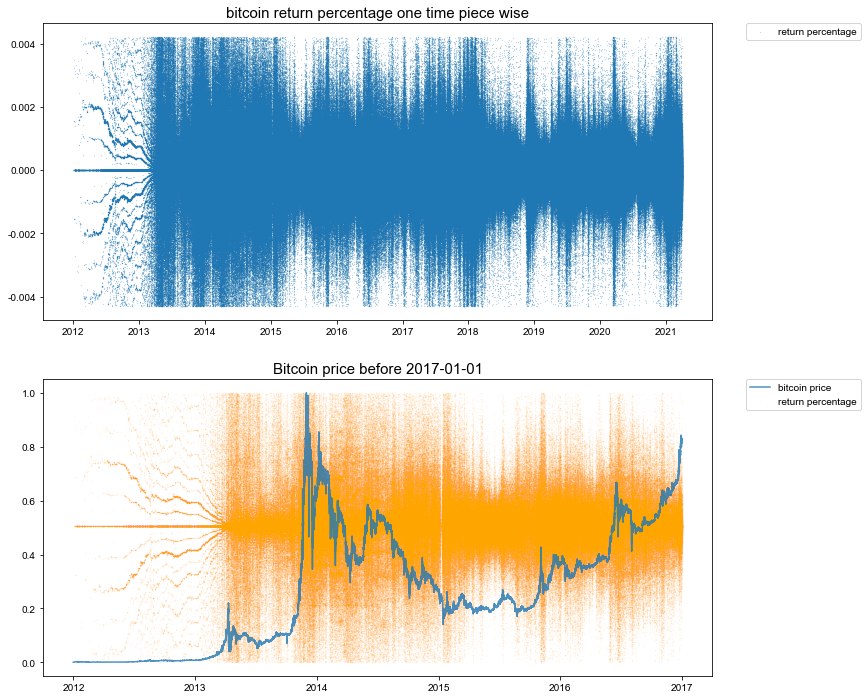

In [16]:
scaler = MinMaxScaler()

# 选定一个时间之前的分析
time_stamp = pd.Timestamp(2017,1,1)

# 图画大了调一下label的字
plt.rcParams.update({'font.size': 10})

# 画图
fig, ax = plt.subplots(2, 1,figsize=(12,12))
ax[0].scatter(df.index, df.Percentage_Return, s=0.01, label="return percentage")
ax[0].set_title("bitcoin return percentage one time piece wise", fontsize=15)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax[1].plot(df[df.index<time_stamp].index, scaler.fit_transform(df[df.index<time_stamp].Weighted_Price.values.reshape(-1,1)), alpha=0.8, label="bitcoin price")
ax[1].scatter(df[df.index<time_stamp].index, scaler.fit_transform(df[df.index<time_stamp].Percentage_Return.values.reshape(-1,1)), s=0.01, c="orange", alpha=0.3, label="return percentage")
ax[1].set_title("Bitcoin price before %s"%time_stamp.strftime('%Y-%m-%d'), fontsize=15)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.draw()

* 小节一下
1. 看起来2013年之前的数据应该是铁定要全删了\
    原因：
        1.1 2012年missing rate太高了
        1.2 return percentage 1个time step的看起来好像其他的都是遵循了某个normal distribution？反正大概都是枣核型的，每一年的这个都很像，感觉还是比较stable的一个特征，可以用来学习。or换言之，每一个时间差他的涨跌幅都还算比较平均，没有什么极端情况。删掉了空值对他的影响也很小。
        1.3 2012年这个就不是很行，不normal，拿来训练也是噪音。建议找到2013年之前的那一个然后把前面的全删了。\
        
2. 2014年的missing没看具体是为什么，但是我猜应该不是分钟颗粒的数据吧，可能是2分钟3分钟的数据？\
    所以2014 15年的return percentage要比其他年份的粗一些？因为时间片越长波动越大？

## TODO：
    如果2014 15 16粒度也是均匀而且比较整齐的话，之后的可以改一下采样的粒度？如果不均匀的话就假装看不见吧，如果有future todo或者可以改进的东西可以把这个拿出来说一说，处理平滑了variance再做模型？

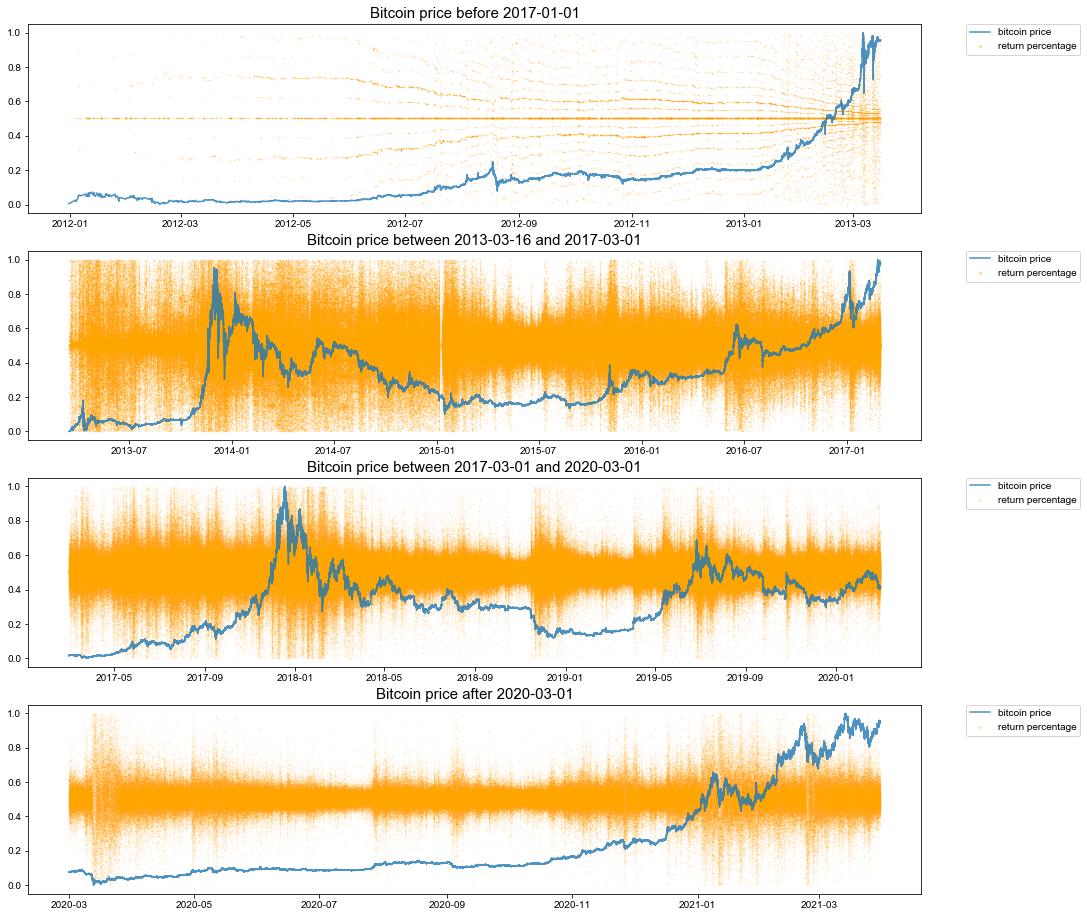

In [17]:
# 选定一个时间之前的分析
stamp1 = pd.Timestamp(2013,3,16)
stamp2 = pd.Timestamp(2017,3,1)
stamp3 = pd.Timestamp(2020,3,1)

# 图画大了调一下label的字
plt.rcParams.update({'font.size': 10})

# 画图
fig, ax = plt.subplots(4, 1,figsize=(16,16))

ax[0].plot(df[df.index<stamp1].index, scaler.fit_transform(df[df.index<stamp1].Weighted_Price.values.reshape(-1,1)), alpha=0.8, label="bitcoin price")
ax[0].scatter(df[df.index<stamp1].index, scaler.fit_transform(df[df.index<stamp1].Percentage_Return.values.reshape(-1,1)), s=0.05, c="orange", alpha=0.3, label="return percentage")
ax[0].set_title("Bitcoin price before %s"%time_stamp.strftime('%Y-%m-%d'), fontsize=15)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=10)


ax[1].plot(df[(df.index>stamp1)&(df.index<stamp2)].index, scaler.fit_transform(df[(df.index>stamp1)&(df.index<stamp2)].Weighted_Price.values.reshape(-1,1)), alpha=0.8, label="bitcoin price")
ax[1].scatter(df[(df.index>stamp1)&(df.index<stamp2)].index, scaler.fit_transform(df[(df.index>stamp1)&(df.index<stamp2)].Percentage_Return.values.reshape(-1,1)), s=0.05, c="orange", alpha=0.3, label="return percentage")
ax[1].set_title("Bitcoin price between %s and %s"%(stamp1.strftime('%Y-%m-%d'), stamp2.strftime('%Y-%m-%d')), fontsize=15)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=10)


ax[2].plot(df[(df.index>stamp2)&(df.index<stamp3)].index, scaler.fit_transform(df[(df.index>stamp2)&(df.index<stamp3)].Weighted_Price.values.reshape(-1,1)), alpha=0.8, label="bitcoin price")
ax[2].scatter(df[(df.index>stamp2)&(df.index<stamp3)].index, scaler.fit_transform(df[(df.index>stamp2)&(df.index<stamp3)].Percentage_Return.values.reshape(-1,1)), s=0.05, c="orange", alpha=0.2, label="return percentage")
ax[2].set_title("Bitcoin price between %s and %s"%(stamp2.strftime('%Y-%m-%d'), stamp3.strftime('%Y-%m-%d')), fontsize=15)
ax[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=10)


ax[3].plot(df[df.index>stamp3].index, scaler.fit_transform(df[df.index>stamp3].Weighted_Price.values.reshape(-1,1)), alpha=0.8, label="bitcoin price")
ax[3].scatter(df[df.index>stamp3].index, scaler.fit_transform(df[df.index>stamp3].Percentage_Return.values.reshape(-1,1)), s=0.05, c="orange", alpha=0.2, label="return percentage")
ax[3].set_title("Bitcoin price after %s"%(stamp3.strftime('%Y-%m-%d')), fontsize=15)
ax[3].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=10)

plt.draw()

## Delete data
    delete data before 2013.3.16

In [18]:
df = df[df.index>stamp1]

## Analysising other Features

### Volume
发现Volume的120min moving avg好像还挺好用的

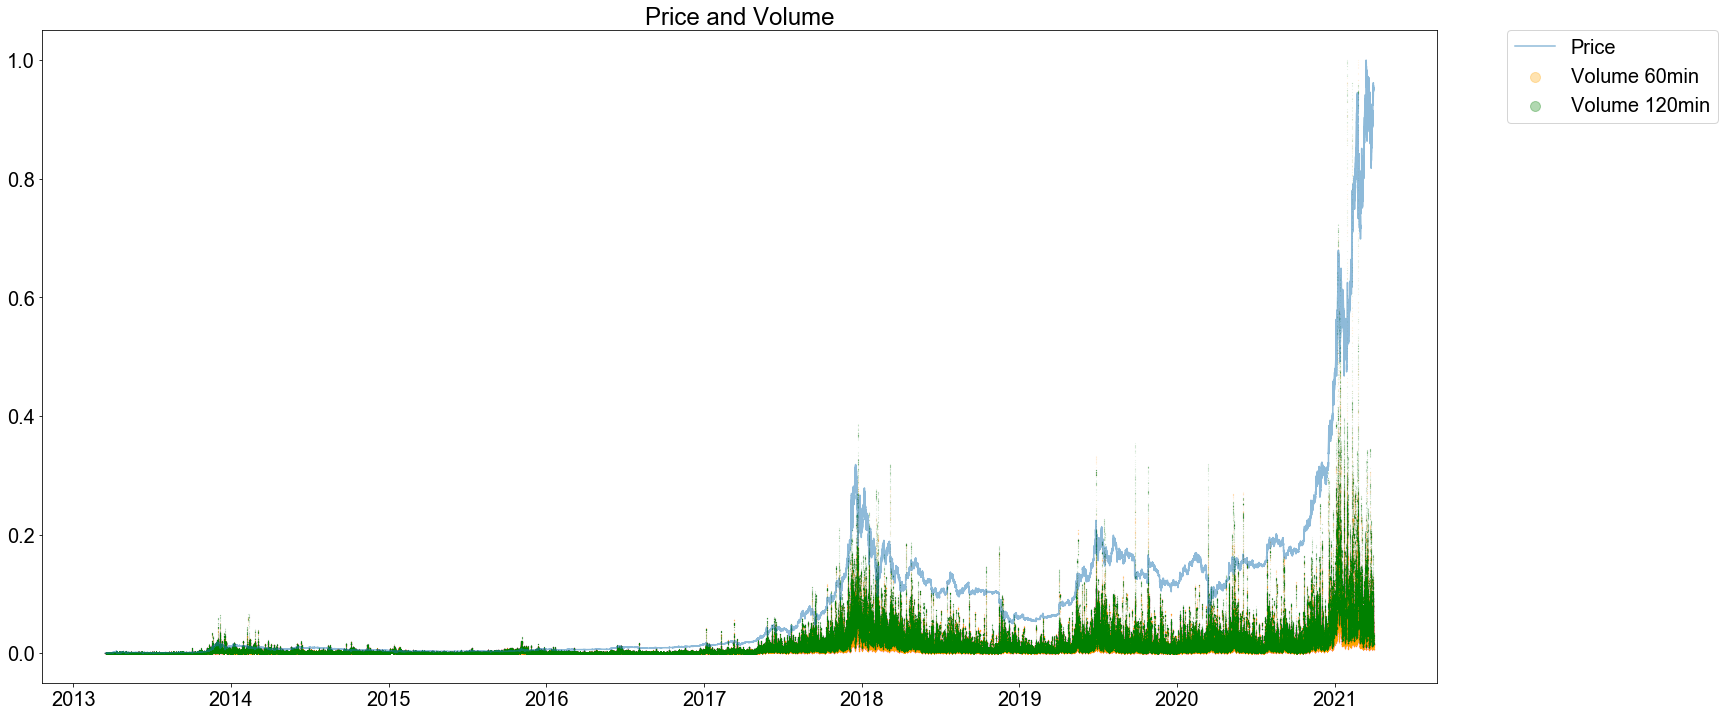

In [19]:
# 加大字体
plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(figsize=(25,12))
ax.plot(df.index, scaler.fit_transform(df.Weighted_Price.values.reshape(-1,1)), alpha=0.5, label='Price')
ax.scatter(df.index, scaler.fit_transform(df.Vol_MA60.values.reshape(-1,1)), alpha=0.3, label='Volume 60min', s=0.01, color='orange')


ax.scatter(df.index, scaler.fit_transform(df.Vol_MA120.values.reshape(-1,1)), alpha=0.3, label='Volume 120min', s=0.01, color='green')
# ax.scatter(df.index, scaler.fit_transform(df.Percentage_Return.values.reshape(-1,1)), alpha=0.3, label='Return percent', s=0.01, color='red')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=100)
ax.set_title("Price and Volume")
plt.draw()

### 关于Feature

1. 我觉得bitcoin price不matter。\
    Reason：我们希望bitcoin记住的是一个趋势的特征，不是actually一个价格的特征。\
    ie：就好比很朴素的讲：画出上影线就是要下跌。这个上影线画在22块和画在220块都是一样的，只要他们的趋势是一样的就都是会跌和具体多少钱的价格没有那么强的关系。\
    结论：我们应该拿bitcoin的return ratio当feature rather than bitcoin price。
    
2. 我发现120分钟的Volume好像很好用，要比1分钟的和走势贴的趋势更近一点，可以拿这个来预测。
    

In [20]:
df_t = df[["Volume_Currency", "Weighted_Price"]].copy(deep=True)
df_t

,Volume_Currency,Weighted_Price
Timestamp,,
2013-03-16 00:13:00,133.317648,46.890000
2013-03-16 00:14:00,120.235950,46.875614
2013-03-16 00:39:00,46.900000,46.900000
2013-03-16 00:49:00,183.355440,46.870000
2013-03-16 00:57:00,83.750004,46.870000
...,...,...
2021-03-30 23:56:00,81259.372187,58692.753339
2021-03-30 23:57:00,428158.146640,58693.226508
2021-03-30 23:58:00,100117.070370,58696.198496


In [21]:
times = [2, 120, 240, 600, 1440, 4320, 7200, 14400, 28800]

In [22]:
for col in df_t.columns:
    for t in times:
        df_t[col+'_ratio_'+str(t)] = df_t[col]/df_t[col].rolling(window=t).mean()
df_t.dropna(inplace=True)
df_t

,Volume_Currency,Weighted_Price,Volume_Currency_ratio_2,Volume_Currency_ratio_120,Volume_Currency_ratio_240,Volume_Currency_ratio_600,Volume_Currency_ratio_1440,Volume_Currency_ratio_4320,Volume_Currency_ratio_7200,Volume_Currency_ratio_14400,Volume_Currency_ratio_28800,Weighted_Price_ratio_2,Weighted_Price_ratio_120,Weighted_Price_ratio_240,Weighted_Price_ratio_600,Weighted_Price_ratio_1440,Weighted_Price_ratio_4320,Weighted_Price_ratio_7200,Weighted_Price_ratio_14400,Weighted_Price_ratio_28800
Timestamp,,,,,,,,,,,,,,,,,,,,
2013-04-30 20:36:00,139.989999,137.990000,0.132139,0.087429,0.110165,0.163181,0.248047,0.216912,0.145162,0.133983,0.135673,1.000482,1.009484,1.002944,0.975548,0.969438,1.002529,0.984850,1.128414,1.151865
2013-04-30 20:37:00,1506.479999,137.990000,1.829951,0.996201,1.187464,1.751493,2.664654,2.334255,1.561912,1.441689,1.459954,1.000000,1.009501,1.002951,0.975621,0.969464,1.002522,0.984846,1.128388,1.151835
2013-04-30 20:38:00,1113.330002,137.990000,0.849932,0.734928,0.875641,1.292445,1.966954,1.724415,1.154323,1.065441,1.078910,1.000000,1.009471,1.002967,0.975694,0.969490,1.002515,0.984843,1.128361,1.151805
2013-04-30 20:39:00,741.639997,137.990000,0.799625,0.491049,0.582964,0.859963,1.310217,1.148416,0.768876,0.709904,0.718695,1.000000,1.009501,1.002984,0.975766,0.969516,1.002509,0.984839,1.128335,1.151774
2013-04-30 20:40:00,942.564822,137.998784,1.119300,0.621329,0.739540,1.093491,1.663550,1.459097,0.977073,0.902291,0.913380,1.000032,1.009612,1.003064,0.975899,0.969604,1.002566,0.984898,1.128381,1.151817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-30 23:56:00,81259.372187,58692.753339,0.708872,1.198122,1.001461,0.738670,0.588387,0.567097,0.570214,0.463320,0.421717,0.999666,0.999355,0.999584,0.998660,1.006009,1.029231,1.050250,1.056144,1.036530
2021-03-30 23:57:00,428158.146640,58693.226508,1.680971,6.051692,5.232474,3.871621,3.096415,2.986077,3.003437,2.440925,2.221882,1.000004,0.999378,0.999611,0.998673,1.006005,1.029228,1.050240,1.056152,1.036537
2021-03-30 23:58:00,100117.070370,58696.198496,0.379034,1.398912,1.226897,0.908864,0.723793,0.698267,0.702565,0.570747,0.519555,1.000025,0.999441,0.999682,0.998728,1.006043,1.029270,1.050275,1.056206,1.036588


In [23]:
# 下面这个写的不太对，内核会算炸了，我想一下怎么解决。
# 应该是要写成一个function 然后apply 这个 好像会快而且不会crush。

In [24]:
df_t.corr('kendall')

,Volume_Currency,Weighted_Price,Volume_Currency_ratio_2,Volume_Currency_ratio_120,Volume_Currency_ratio_240,Volume_Currency_ratio_600,Volume_Currency_ratio_1440,Volume_Currency_ratio_4320,Volume_Currency_ratio_7200,Volume_Currency_ratio_14400,Volume_Currency_ratio_28800,Weighted_Price_ratio_2,Weighted_Price_ratio_120,Weighted_Price_ratio_240,Weighted_Price_ratio_600,Weighted_Price_ratio_1440,Weighted_Price_ratio_4320,Weighted_Price_ratio_7200,Weighted_Price_ratio_14400,Weighted_Price_ratio_28800
Volume_Currency,1.000000,0.429121,0.267883,0.556021,0.563979,0.572485,0.578710,0.585372,0.587781,0.590792,0.594707,-0.009477,0.001631,0.003996,0.007562,0.011950,0.025580,0.035035,0.045944,0.068989
Weighted_Price,0.429121,1.000000,-0.000629,0.054638,0.053505,0.051589,0.049291,0.047191,0.045903,0.045328,0.045934,0.000198,0.003956,0.005822,0.009879,0.017104,0.034291,0.046929,0.062234,0.092296
Volume_Currency_ratio_2,0.267883,-0.000629,1.000000,0.409154,0.402065,0.392689,0.387478,0.378019,0.375590,0.373149,0.369333,-0.030989,-0.004388,-0.003165,-0.001887,-0.001096,-0.000544,-0.000357,-0.000165,-0.000107
Volume_Currency_ratio_120,0.556021,0.054638,0.409154,1.000000,0.902575,0.846810,0.823805,0.798292,0.792727,0.787161,0.777951,-0.017085,-0.007068,-0.003067,-0.000222,0.001392,0.004851,0.007965,0.011623,0.017427
Volume_Currency_ratio_240,0.563979,0.053505,0.402065,0.902575,1.000000,0.893429,0.856217,0.824148,0.817177,0.810484,0.799944,-0.016550,-0.006349,-0.003674,-0.000269,0.001777,0.004914,0.008071,0.011675,0.017590
Volume_Currency_ratio_600,0.572485,0.051589,0.392689,0.846810,0.893429,1.000000,0.908301,0.860722,0.850097,0.840917,0.827817,-0.016139,-0.004993,-0.002424,0.000215,0.003341,0.005966,0.008902,0.012071,0.017835
Volume_Currency_ratio_1440,0.578710,0.049291,0.387478,0.823805,0.856217,0.908301,1.000000,0.903850,0.885345,0.871451,0.854208,-0.015774,-0.003839,-0.000984,0.002418,0.005611,0.009678,0.012074,0.014825,0.019921
Volume_Currency_ratio_4320,0.585372,0.047191,0.378019,0.798292,0.824148,0.860722,0.903850,1.000000,0.946517,0.917389,0.890061,-0.015288,-0.002423,0.000293,0.003722,0.006636,0.014928,0.018223,0.021348,0.025454
Volume_Currency_ratio_7200,0.587781,0.045903,0.375590,0.792727,0.817177,0.850097,0.885345,0.946517,1.000000,0.943772,0.910516,-0.015069,-0.001296,0.001693,0.005551,0.008836,0.017561,0.022214,0.026860,0.030543
Volume_Currency_ratio_14400,0.590792,0.045328,0.373149,0.787161,0.810484,0.840917,0.871451,0.917389,0.943772,1.000000,0.942032,-0.014885,-0.000552,0.002605,0.006826,0.010763,0.021247,0.028007,0.036769,0.042610
